# Projekt 2, kamień milowy 2
### Sebastian Deręgowski, Bartosz Jamroży, Dawid Janus

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator

In [3]:
unlabelled_df = pd.read_csv("AllBooks_baseline_DTM_Unlabelled.csv")
labelled_df = pd.read_csv("AllBooks_baseline_DTM_Labelled.csv")

Zanim przejdziemy do modelowania, przeprowadźmy lematyzację i stemming słów z naszego zbioru:

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
p_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

def stemming_process(text):
    #Stemming
    nltk_stemedList = []
    for word in text:
        nltk_stemedList.append(p_stemmer.stem(word))
    return nltk_stemedList

def lemma_process(text):

    #Lemmatization
    nltk_lemmaList = []
    for word in text:
        nltk_lemmaList.append(wordnet_lemmatizer.lemmatize(word))
    return nltk_lemmaList
    

stemming_lemma_list = lemma_process(stemming_process(unlabelled_df.columns.values))
lemma_list = lemma_process(unlabelled_df.columns.values)
stemming_list = stemming_process(unlabelled_df.columns.values)
lemma_stemming_list = stemming_process(lemma_process(unlabelled_df.columns.values))

    
print(f"Wyjściowa lista: {len(unlabelled_df.columns.values)}")

#for i in range(len(df.columns.values)):
#    if df.columns.values[i] != lemma_list[i]:
#        print(f"{df.columns.values[i]} ----> {lemma_list[i]}")
        
stemming_list_unique = list(set(stemming_list))
print(f"Lista po stemmingu: {len(stemming_list_unique)}")
    
lemma_list_unique = list(set(lemma_list))
print(f"Lista po lematyzacji: {len(lemma_list_unique)}")

stemming_lemma_list_unique = list(set(stemming_lemma_list))
print(f"Lista po stemmingu i lematyzacji: {len(stemming_lemma_list_unique)}")

lemma_stemming_list_unique = list(set(lemma_stemming_list))
print(f"Lista po lematyzacji i stemmingu: {len(lemma_stemming_list_unique)}")

Wyjściowa lista: 8266
Lista po stemmingu: 5512
Lista po lematyzacji: 7403
Lista po stemmingu i lematyzacji: 5500
Lista po lematyzacji i stemmingu: 5506


Jak widzimy, oba procesy doprowadzają do znacznego uproszczenia listy słów (o około 1/3). W zależności od tego, czy dokonamy stemmingu, czy lematyzacji, czy obydwu, czy obydwu w odwrotnej kolejności, otrzymujemy inne różne liczebności naszych zbiorów. Trudno oszacować, jaka kolejność jest właściwa.

In [5]:
conflict_list = ['ass','as','a']
print("Stemming:")
for word in conflict_list:
    print(f"{word} ---> {p_stemmer.stem(word)}")
print("Lematyzacja:")
for word in conflict_list:
    print(f"{word} ---> {wordnet_lemmatizer.lemmatize(word)}")

Stemming:
ass ---> ass
as ---> as
a ---> a
Lematyzacja:
ass ---> as
as ---> a
a ---> a


Powyższy przykład pokazuje, że proces lematyzacji znacząco upraszcza słowa poprzez ucinanie końcówek, co w skrajnych przypadkach może doprowadzić do absurdalnych wyników.

Zdefiniujmy funkcję, która pozwoli nam zcalić kolumny, które po stemmingu i lematyzacji są takie same:

In [6]:
def concat_columns(df,lemat_list):
    df_copy = df.copy(deep=True)
    column_transformed = {}
    new_df = pd.DataFrame()
    for i, word in enumerate(lemat_list):
        if word in column_transformed:
            column_transformed[word].append(i)
        else:
            column_transformed[word]=[i]
    for word, value in column_transformed.items():
        if len(value) > 1:
            column_sum = df_copy.iloc[:,value[0]]
            for i in range(len(value)-1):
                column_sum += df_copy.iloc[:,value[i+1]]
            new_df[word]=column_sum
        else:
            new_df[word]=df_copy.iloc[:,value[0]]
    return new_df

Zajmijmy się teraz usunięciem słów, które pojawiają się w tylko jednej obserwacji. W tym celu wywołajmy ponownie funkcję z pierwszego kamienia milowego zliczającą wszystkie wyrazy, które występują daną ilość razy.

In [7]:
def word_to_count(df):
    word_to_count = {}
    for i, word in enumerate(df.columns.values):
        word_to_count[word]=sum(df.iloc[:,i])
    return word_to_count

In [8]:
def count_words_plot(df):
    
    word_to_count_dict = word_to_count(df)
    
    count_to_word = {}
    for i,j in word_to_count_dict.items():
        if j in count_to_word:
            count_to_word[j].append(i)
        else:
            count_to_word[j]=[i]
    
    count_to_word_count = {}
    for i in count_to_word.keys():
        count_to_word_count[i]=len(count_to_word[i])
    count_df = pd.DataFrame.from_dict(count_to_word_count,orient='index').reset_index()
    plt.bar(count_df.iloc[:,0],count_df.iloc[:,1])
    plt.xlim(0,30)
    plt.show()

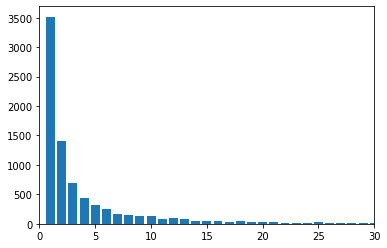

In [9]:
count_words_plot(unlabelled_df)

Teraz zobaczmy, jak będzie wyglądał ten wykres po zastosowaniu lematyzacji i/lub stemmingu:

stemming


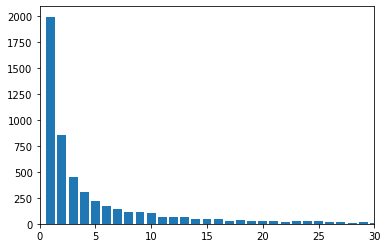

lemma


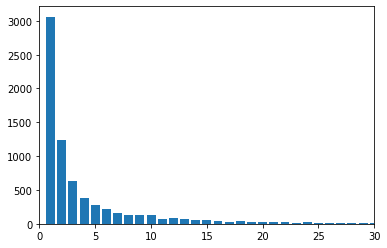

lemma+stemming


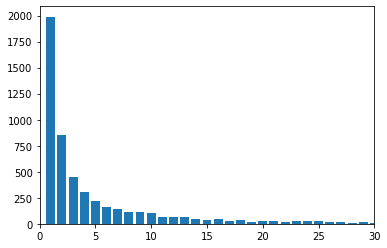

stemming+lemma


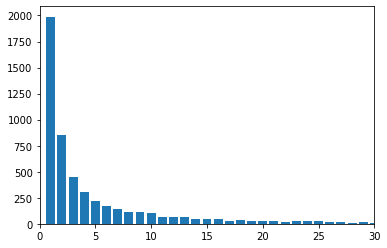

In [10]:
lists = [stemming_list,lemma_list,lemma_stemming_list,stemming_lemma_list]
lists_names = ['stemming','lemma','lemma+stemming','stemming+lemma']
for i in range(len(lists)):
    print(lists_names[i])
    count_words_plot(concat_columns(unlabelled_df,lists[i]))

Jak widzimy, sama lematyzacja usuwa dość mało pojedynczych wyrazów. Z tego powodu zdecydowaliśmy się na zastosowanie najpierw stemmingu, a potem lematyzacji.

Teraz możemy stworzyć funkcję, która usuwa z ramki danych wszystkie słowa, które pojawiają się tylko raz.

In [11]:
def delete_ones(df):
    without_ones=pd.DataFrame()
    word_to_count_dict = word_to_count(df)
    for i,j in word_to_count_dict.items():
        if j>1:
            without_ones[i]=df.loc[:,i]
    return without_ones

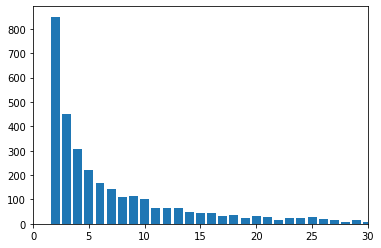

In [12]:
transformed_df = delete_ones(concat_columns(unlabelled_df,stemming_lemma_list))
count_words_plot(transformed_df)

In [13]:
transformed_df.shape

(590, 3512)

Jak widzimy, nie ma już żadnych słów, które pojawiają się w tylko jednej obserwacji.

Teraz zastosujmy algorytm PCA dla naszego zbioru:

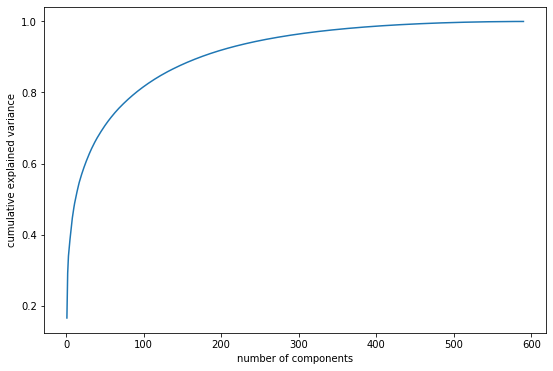

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(transformed_df)

plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Na podstawie wykresu szacujemy liczbę komponentów na 500:

In [15]:
pca_new = PCA(n_components=500).fit_transform(transformed_df)
pca_df = pd.DataFrame(pca_new)
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-2.600428,5.226662,2.755641,3.690292,10.122325,9.565113,-34.469841,42.508178,8.625799,4.831410,...,0.012696,0.006027,-0.012404,-0.006509,0.011339,-0.011704,0.016132,0.005907,-0.006970,-0.018972
1,-2.051307,0.549099,1.463812,1.657847,3.565442,0.922275,-2.556695,-1.663834,-6.281033,-3.753512,...,-0.014542,0.022545,0.008567,0.021845,-0.002812,-0.029199,-0.047414,0.009764,0.021005,0.037539
2,-3.287525,3.997649,0.303774,6.471726,17.810520,8.211867,-6.002519,-4.466937,-27.951271,-10.398518,...,0.037327,-0.017840,-0.034697,-0.000171,0.002529,0.012343,0.010855,-0.022822,0.019137,0.014718
3,-3.390642,1.194953,0.598959,2.276266,8.030459,3.480302,-2.913930,-3.757471,-9.241359,-6.010299,...,-0.002267,0.011358,0.013902,-0.042471,-0.013240,-0.018243,0.012138,-0.027242,-0.026487,0.025000
4,-3.945944,-0.857226,0.119557,-0.747044,1.463924,-0.359561,-0.825771,-0.458238,-2.740588,-1.442765,...,-0.314115,0.158931,0.314488,0.174354,0.041127,-0.039344,0.056631,0.298014,-0.105741,-0.230134


Przejdźmy do modelowania. Stwórzmy funkcję, która będzie przyjmowała model, a następnie dzięki TSNE wizualizowała je w 2D:

In [16]:
def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(16,16))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    ax.axis('off')
    # add labels
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txts.append(txt)

    return f, ax, sc, txts

In [17]:
from sklearn.manifold import TSNE

def modeling(model,df):
    try:
        model.fit(df)
        y = model.predict(df)
    except:
        y = model.fit_predict(df)
    tsne_proj = TSNE(random_state=1500100900).fit_transform(df)
    scatter(tsne_proj, y)
    plt.show()

Sprawdźmy jak będzie wyglądał clustering dla KMeans:

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


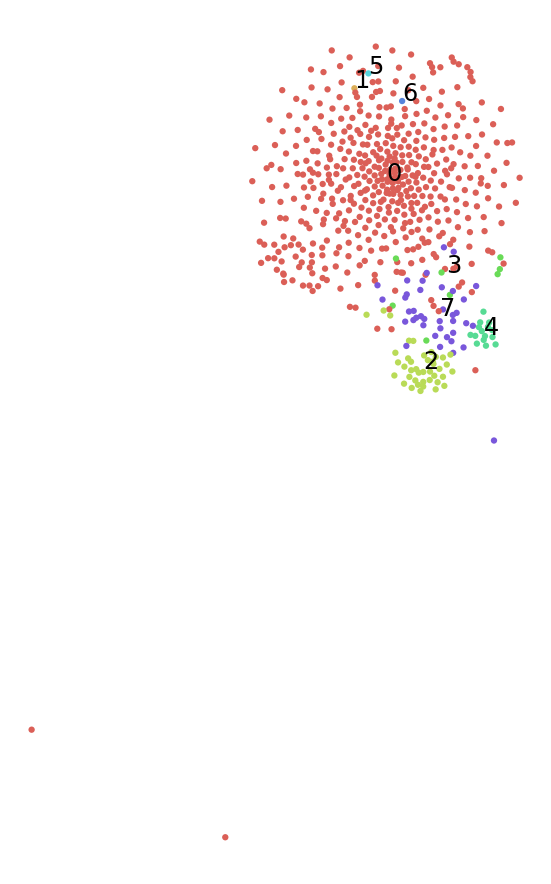

In [19]:
from sklearn.cluster import KMeans

modeling(KMeans(random_state=0),transformed_df)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


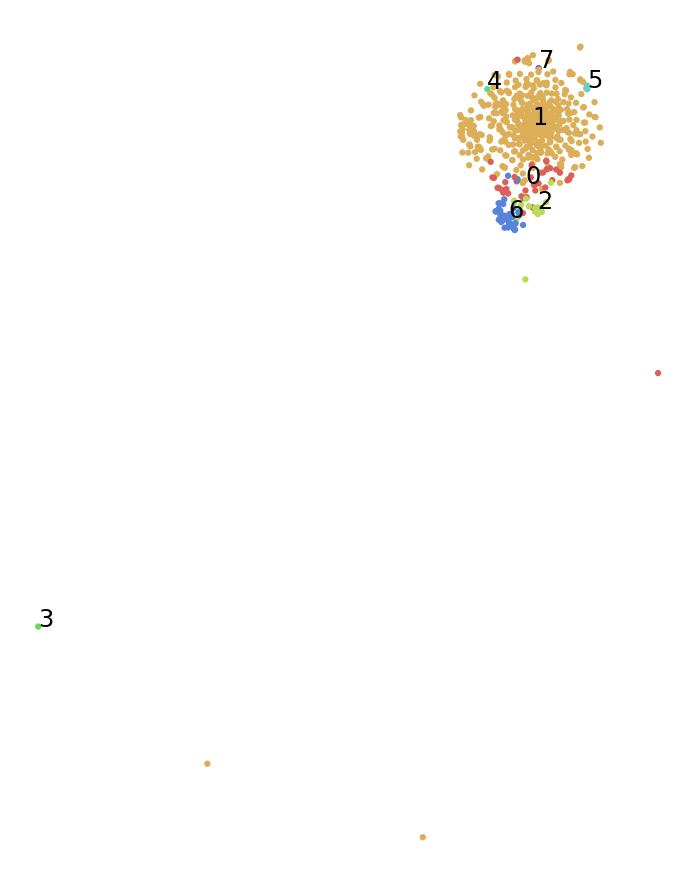

In [20]:
modeling(KMeans(random_state=0),pca_df)

Nieoczekiwanie model ten (być może przypadkowo) dobrał optymalną liczbę klastrów (z poprzedniego kamienia milowego wiemy, że docelowo powinno ich być 8). Widzimy dodatkowo, że zastosowanie PCA nie miało większego wpływu na "rozrzut" obserwacji, poza oddaleniem obserwacji odstających.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


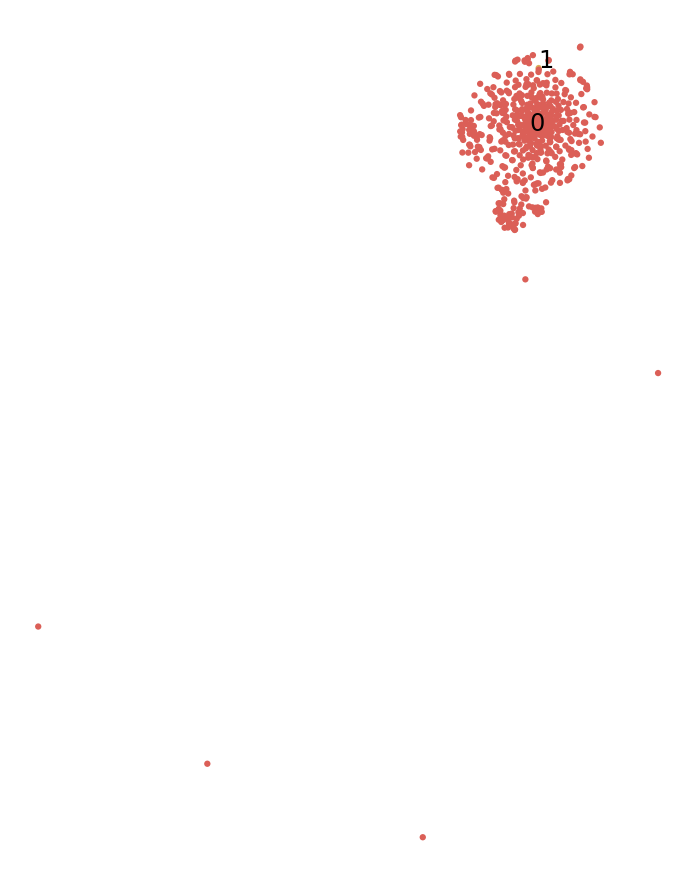

In [21]:
from sklearn.cluster import AgglomerativeClustering
modeling(AgglomerativeClustering(linkage='complete'),pca_df)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


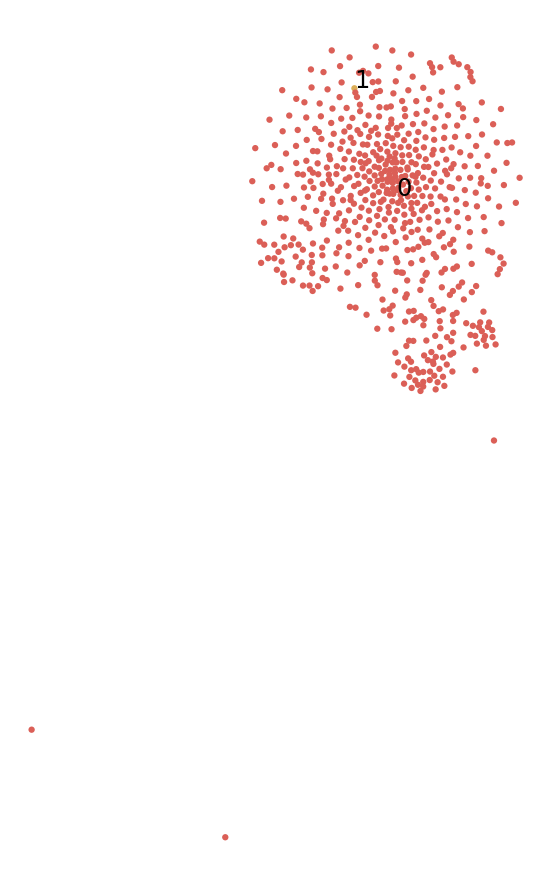

In [22]:
from sklearn.cluster import AgglomerativeClustering
modeling(AgglomerativeClustering(linkage='complete'),transformed_df)

Model ten poradził sobie zdecydowanie gorzej, dobierając jedynie 2 klastry. Na koniec zastosujmy jeszcze algorytm klastrowania opartego na gęstości, DBSCAN:

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


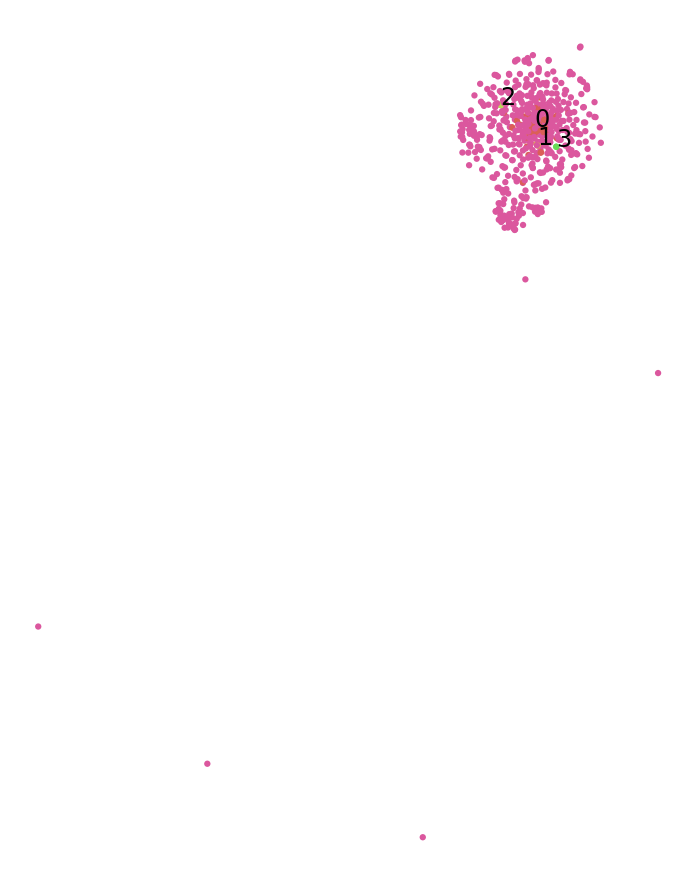

In [23]:
from sklearn.cluster import DBSCAN
modeling(DBSCAN(eps=4, min_samples=2),pca_df)